In [1]:
# Import panads
import pandas as pd
# Read parquet file


# WARNING THIS EATS ALL YOUR RAM DO NOT RUN THIS WITHOUT 16GB OF RAM + ZRAM
df = pd.read_parquet('train.parquet', columns=["tokens"])
# use one tenth of the data
df = df.sample(frac=0.1, random_state=1)
# Print column names
print(df.columns)

# Remove all commas
df = df.apply(lambda x: x.str.replace(',', ' '))

Index(['tokens'], dtype='object')


In [1]:
# Perform TF-IDF on the tokenized text
from sklearn.feature_extraction.text import TfidfVectorizer

# check if tfid pickle exists
import os
import pickle
if os.path.isfile('tfidf.pkl'):
    # load tfidf
    tfidf = pickle.load(open('tfidf.pkl', 'rb'))
else:
    # create tfidf
    tfidf = TfidfVectorizer(max_features=2**12, stop_words='english', smooth_idf=True)
    tfidf.fit(df['tokens'])
    # save tfidf
    pickle.dump(tfidf, open('tfidf.pkl', 'wb'))

# Print vocabulary of tfidf
#print(tfidf.vocabulary_)

In [39]:
# Find all parquet files within dataset
import glob
import pandas as pd
parquet_files = glob.glob('train.parquet/*.parquet')

out_path = 'vectorised.parquet'
for file in parquet_files:
    # Read parquet file
    df = pd.read_parquet(file)
    # If column "tokens" is empty, skip
    if df.empty:
        continue
    # Add new column for tfidf
    df['tfidf'] = None
    
    # Remove all commas
    df['tokens'] = df['tokens'].str.replace(',', ' ')
    # Transform text into tfidf vectors
    X = tfidf.transform(df['tokens']).todense()
    # Append to dataframe with column name "tfidf"
    df['tfidf'] = X.tolist()

    # Remove tokens column
    df = df.drop(columns=['tokens'])
    # Save to parquet
    df.to_parquet(out_path + '/' + file.split('/')[1])
    print("Saved " + file.split('/')[1])

Saved part.0.parquet
Saved part.1.parquet
Saved part.10.parquet
Saved part.108.parquet
Saved part.11.parquet
Saved part.113.parquet
Saved part.114.parquet
Saved part.116.parquet
Saved part.117.parquet
Saved part.118.parquet
Saved part.119.parquet
Saved part.12.parquet
Saved part.120.parquet
Saved part.121.parquet
Saved part.122.parquet
Saved part.123.parquet
Saved part.124.parquet
Saved part.125.parquet
Saved part.126.parquet
Saved part.127.parquet
Saved part.128.parquet
Saved part.129.parquet
Saved part.13.parquet
Saved part.130.parquet
Saved part.131.parquet
Saved part.132.parquet
Saved part.133.parquet
Saved part.134.parquet
Saved part.135.parquet
Saved part.136.parquet
Saved part.137.parquet
Saved part.138.parquet
Saved part.139.parquet
Saved part.14.parquet
Saved part.140.parquet
Saved part.141.parquet
Saved part.142.parquet
Saved part.143.parquet
Saved part.144.parquet
Saved part.145.parquet
Saved part.146.parquet
Saved part.147.parquet
Saved part.148.parquet
Saved part.149.parqu

KeyboardInterrupt: 

In [20]:
# Try to train a logistic regression model
import pandas as pd
# if df already exists, delete it
try:
    del df
except:
    pass
df = pd.read_parquet('vectorised.parquet')
# Sample 10% of the data
df = df.sample(frac=0.4, random_state=2)
print(df.columns)
# Split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['tfidf'], df['type'], test_size=0.1, random_state=42)


Index(['id', 'type', 'tfidf'], dtype='object')


In [21]:
# import logistic CV
from sklearn.linear_model import SGDClassifier
model = SGDClassifier(verbose=1, n_jobs=-1, max_iter=1000, tol=1e-3)
# Fit model

# Convert list of lists to list of numpy arrays
import numpy as np
X_train = [np.array(x) for x in X_train]
model.fit(X_train, y_train)

-- Epoch 1
Norm: 15.67, NNZs: 4090, Bias: -1.512815, T: 87199, Avg. loss: 0.084106
Total training time: 0.38 seconds.
-- Epoch 2
Norm: 14.48, NNZs: 4091, Bias: -1.365730, T: 174398, Avg. loss: 0.066955
Total training time: 0.74 seconds.
-- Epoch 3
Norm: 14.09, NNZs: 4091, Bias: -1.297552, T: 261597, Avg. loss: 0.066225
Total training time: 1.10 seconds.
-- Epoch 4
Norm: 13.85, NNZs: 4091, Bias: -1.120005, T: 348796, Avg. loss: 0.065473
Total training time: 1.45 seconds.
-- Epoch 5
Norm: 13.73, NNZs: 4091, Bias: -1.214185, T: 435995, Avg. loss: 0.065363
Total training time: 1.90 seconds.
-- Epoch 6
Norm: 13.65, NNZs: 4091, Bias: -1.162547, T: 523194, Avg. loss: 0.065215
Total training time: 2.35 seconds.
-- Epoch 7
Norm: 13.57, NNZs: 4091, Bias: -1.206358, T: 610393, Avg. loss: 0.065122
Total training time: 2.75 seconds.
Convergence after 7 epochs took 2.75 seconds


SGDClassifier(n_jobs=-1, verbose=1)

In [22]:
del X_train, y_train, df

In [23]:
# Evaluate with accuracy and confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# import test dataset
df = pd.read_parquet('test.parquet')
# Get 10% of the data
df = df.sample(frac=0.1, random_state=42)

# Remove all commas
df['tokens'] = df['tokens'].str.replace(',', ' ')

Accuracy: 0.32010147205945405


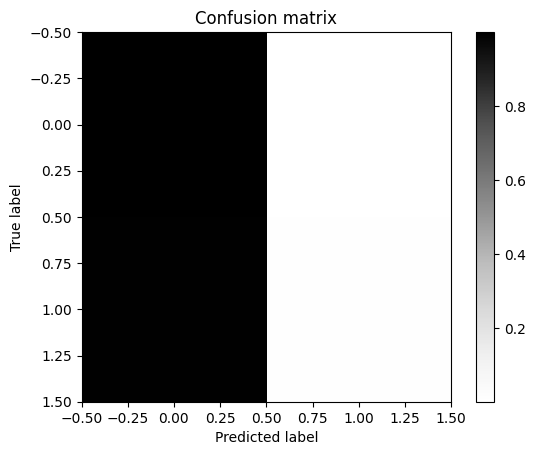

In [24]:
# Predict
X_test = tfidf.transform(df['tokens']).todense().tolist()
y_pred = model.predict(X_test)

# Metrics
# Accuracy
print("Accuracy: " + str(accuracy_score (df['type'], y_pred)))

# Confusion matrix
cm = confusion_matrix(df['type'], y_pred, normalize='true')
# Black white

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greys)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [8]:
# The onion test, this should be classified as fake news, all shall bow before the big onion, the onion is the best. All hail the onion.

article = """
WASHINGTON—Drawing swift rebukes from regulators and industry activists, the Biden administration came under fire Thursday for breaking child labor laws after half of the federal cabinet was revealed to be under the age of 10. “We’ve confirmed that there are department heads as young as six running agencies like the Department of Agriculture and the Justice Department,” said industry watchdog Stephanie Wilson, confirming that White House chief of staff Jeff Zients would often pay the minors in candy to complete routine tasks such as completing the President’s Daily Brief with crayons and construction paper. “You can’t just put a toddler named Mason in an oversized suit, give him the nuclear football, and tell him to head up the largest security apparatus in the world, but apparently that’s not a problem for President Biden and the Department of Defense. This isn’t merely an egregious violation of basic labor laws. Many of these cabinet secretaries are scared and don’t know where their parents are.” At press time, the White House had responded to such criticism by pointing to its many teenage cabinet members such as 17-year-old Transportation Secretary Pete Buttigieg.
"""

# Remove all commas
article = article.replace(',', ' ')
# Transform text into tfidf vectors
X_test = tfidf.transform([article]).todense().tolist()

# Predict
y_pred = model.predict(X_test)
print("Predicted: " + y_pred[0])

Predicted: fake
